<a href="https://colab.research.google.com/github/dbssn/DMML2019_Team_Microsoft/blob/master/Copy_of_3_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [0]:
# Imports
import pandas as pd

In [0]:
# Load data set
df_0 = pd.read_csv("https://drive.switch.ch/index.php/s/Gs1wqzxkNeCppeC/download")

In [5]:
# Copy to easily reset, without loading the data set again
df = df_0
df.sample(3)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Year,Month,Weekday,LenViol,TMAX,MeanMaxTemp3Days,ApproxCreationDate,DaysInBusiness
84373,1184391,PRESTO,2087731,restaurant,Risk 1 (High),131 N CLINTON ST,60661,2012-06-14,canvass,Pass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.884188,-87.641120,2012,6,3,622,30.0,26.300000,2011-03-29,443.0
76631,1501570,ISLA PILIPINA RESTAURANT,1445451,restaurant,Risk 1 (High),2501 W LAWRENCE AVE,60625,2014-11-06,canvass,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.968483,-87.691409,2014,11,3,1492,11.1,20.566667,2003-11-07,4017.0
67777,250833,RESTAURANT 2 AMIGOS,21363,restaurant,Risk 1 (High),2320 N MILWAUKEE AVE,60647,2010-06-11,canvass,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.923232,-87.698112,2010,6,4,1328,31.1,23.866667,2002-05-10,2954.0


In [6]:
df.shape

(122595, 21)

# 1. Preprocessing

Some features, such as "Inspection ID", "DBA Name", are not too useful when it comes to predicting the outcome of the inspection. Therefore, those columns are dropped.

In [7]:
# Drop columns that are not useful
df = df.drop(["Inspection ID", "DBA Name", "License #", "Address", "Zip", "Inspection Date", "Violations", "ApproxCreationDate"], axis = 1)
df.sample(3)

,Facility Type,Risk,Inspection Type,Results,Latitude,Longitude,Year,Month,Weekday,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness
1641,school,Risk 1 (High),canvass,Pass,41.689939,-87.637608,2010,4,1,772,15.6,12.766667,2909.0
11433,restaurant,Risk 1 (High),license,Fail,42.012010,-87.674686,2015,11,1,2975,17.2,15.900000,21.0
109121,grocery store,Risk 2 (Medium),license,Fail,41.784037,-87.613315,2011,6,3,609,27.2,22.966667,6.0


### 1.1 Standardization

The first step is to normalise the numerical features :

*   Latitude
*   Longitude
*   LenViol
*   TMAX
*   MeanMaxTemp3Days
*   DaysInBusiness


In [8]:
# Work on copy of df
df_prep = df[["Latitude", "Longitude", "LenViol", "TMAX", "MeanMaxTemp3Days", "DaysInBusiness", "Facility Type", "Risk", "Inspection Type", "Year", "Month", "Weekday", "Results"]]
df_prep.sample(1)

,Latitude,Longitude,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness,Facility Type,Risk,Inspection Type,Year,Month,Weekday,Results
15106,41.913601,-87.648209,809,5.0,10.4,3427.0,restaurant,Risk 1 (High),canvass,2012,12,0,Pass


In [9]:
# Standardization
from sklearn.preprocessing import StandardScaler
standardize = StandardScaler()
standardize.fit(df_prep.iloc[:, :6])
df_prep.iloc[:, :6] = standardize.transform(df_prep.iloc[:, :6])
df_prep.sample(1)

,Latitude,Longitude,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness,Facility Type,Risk,Inspection Type,Year,Month,Weekday,Results
112748,-0.011176,-0.824876,0.023469,-1.835672,-1.47932,0.151624,restaurant,Risk 2 (Medium),suspected food poisoning re-inspection,2012,1,4,Pass


### 1.2 Encoding

The following features need to be encoded :

*   Facility Type
*   Risk
*   Inspection Type
*   Year
*   Month
*   Weekday


In [0]:
# Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#One hot encoding
one_hot = OneHotEncoder(categories="auto")
cat_to_onehot = one_hot.fit_transform(df_prep[["Facility Type", "Risk", "Inspection Type", "Year", "Month", "Weekday"]]).toarray()
cat_to_onehot = pd.DataFrame(cat_to_onehot)

# Generate X
feature_names = ["Latitude", "Longitude", "LenViol", "TMAX", "MeanMaxTemp3Days", "DaysInBusiness"]
X = df_prep[feature_names]
X = pd.concat((X, cat_to_onehot), axis=1)

# Generate y
lab_encoder = LabelEncoder()
cat_to_label = lab_encoder.fit_transform(df_prep["Results"])
Y = pd.DataFrame(cat_to_label)

In [11]:
X.sample(1)

,Latitude,Longitude,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
82803,-1.140445,-1.091196,-1.005143,0.838906,1.029382,-0.488405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
Y.sample(5)

,0
57151,1
106698,1
73545,1
56024,0
95643,1


### 1.3 Splitting the data set

In [0]:
# Split train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=72)

# 2. Prediction

### 2.1 Base rate

In [14]:
# The base rest is defined as : size(most frequent class)/size(dataset)
failCount = df[df["Results"] == "Fail"].shape[0]
passCount = df[df["Results"] == "Pass"].shape[0]

if passCount > failCount :
  print("The most frequent class is " + "'Pass' (" + str(passCount) + ") VS 'Fail' (" + str(failCount)+ ").")
else :
   print("The most frequent class is " + "'Fail' (" + str(failCount) + ") VS 'Pass' (" + str(passCount)+ ").")

The most frequent class is 'Pass' (92447) VS 'Fail' (30148).


In [15]:
# Base rate
br = max(passCount, failCount)/(passCount + failCount)

print("The base rate is : " + str(br))

The base rate is : 0.754084587462784


### 2.2 Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic regression with cross-validation
LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
LR.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [17]:
# Train accuracy
LR.score(X_train,Y_train)

0.8465169868265426

In [18]:
# Test accuracy
LR.score(X_test, Y_test)

0.8419185121742322

In [0]:
# Because the name of the column will disappear after one-hot encoding, we rename the dataframe
X.columns=['Latitude','Longitude','LenViol','TMAX', 'MeanMaxTemp3Days','DaysInBusiness','bakery', 'catering','childrens services facility','daycare (2 - 6 years)', 'daycare (under 2 years)','daycare above and under 2 years', 'daycare combo 1586',
        'gas station', 'golden diner', 'grocery store', 'hospital',
        'liquor', 'long term care', 'mobile food dispenser',
        'mobile food preparer', 'restaurant', 'school',
        'shared kitchen user (long term)', 'special event', 'tavern',
        'wholesale','Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)','canvass', 'canvass re-inspection', 'complaint',
        'complaint re-inspection', 'complaint-fire', 'consultation',
        'license', 'license re-inspection', 'license-task force',
        'recent inspection', 'short form complaint',
        'short form fire-complaint', 'suspected food poisoning',
        'suspected food poisoning re-inspection', 'tag removal',
        'task force liquor 1475',2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,"m1","m2","m3","m4","m5","m6","m7","m8","m9","m10","m11","m12",0, 1, 2, 3, 4, 5, 6]


### 2.3 Find the important variables by Logistic Regression's coefficient

In [20]:
coef=LR.coef_[0]
abs_coef=list(abs(coef))
abs_coef.sort(reverse=True)
coef_pos=list(abs(coef))
abs_coef[:5]
for i in range(5):
  num=coef_pos.index(abs_coef[i])
  print(X.columns[num])
  print(coef[num])

license-task force
-2.732689057318292
task force liquor 1475
-2.484110608117668
suspected food poisoning re-inspection
2.3259483424428318
tag removal
2.00960553873777
LenViol
-1.767820822222291


### 2.4 Feature selection using Randomforest and dimension reduction using PCA

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

clf = RandomForestClassifier()
clf = clf.fit(X,Y)
thre=0.008
model = SelectFromModel(clf,prefit=True,threshold=thre)
x_select_ran = pd.DataFrame(model.transform(X))

pca = PCA(n_components=20, svd_solver='auto')
pca.fit(X)
x_select_pca=pd.DataFrame(pca.transform(X))

### 2.5 Compare the accuracy score between algorithms

In [23]:
%tensorflow_version 2.x
from sklearn.svm import SVC
from sklearn import tree,preprocessing
from sklearn.linear_model import LogisticRegression,Lasso,Ridge
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras import layers,optimizers
from keras.wrappers import scikit_learn


kf = KFold(n_splits=5, random_state=None, shuffle=True)
out=[]

def gbc(x,y):
    clf = GradientBoostingClassifier()
    scores = cross_val_score(clf,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def ada(x,y):
    clf = AdaBoostClassifier()
    scores = cross_val_score(clf,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def qda(x,y):
    clf=QuadraticDiscriminantAnalysis()
    scores = cross_val_score(clf,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def mlp(x,y):
    mlp=MLPClassifier()
    scores = cross_val_score(mlp,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def bayes(x,y):
    clf = GaussianNB()
    scores = cross_val_score(clf,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def knn(x,y):
    neigh = KNeighborsClassifier()
    scores = cross_val_score(neigh,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def logistic(x,y):
    classifier = LogisticRegression()
    scores = cross_val_score(classifier,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def forest(x,y):
    forest = RandomForestClassifier()
    scores = cross_val_score(forest,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def xg(x,y):
    x=np.array(x)
    xgbc=xgb.XGBClassifier()
    scores = cross_val_score(xgbc, x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def tr(x,y):
    tre = tree.DecisionTreeClassifier()
    scores = cross_val_score(tre,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def sv(x,y):
    clf = SVC()
    scores = cross_val_score(clf,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def pipe(x,y):
    gbc(x,y)
    ada(x,y)
    qda(x,y)
    mlp(x,y)
    bayes(x,y)
    knn(x,y)
    logistic(x,y)
    forest(x,y)
    xg(x,y)
    tr(x,y)
    sv(x,y)

pipe(X,Y)
pipe(x_select_pca,Y)
pipe(x_select_ran,Y)

TensorFlow is already loaded. Please restart the runtime to change versions.


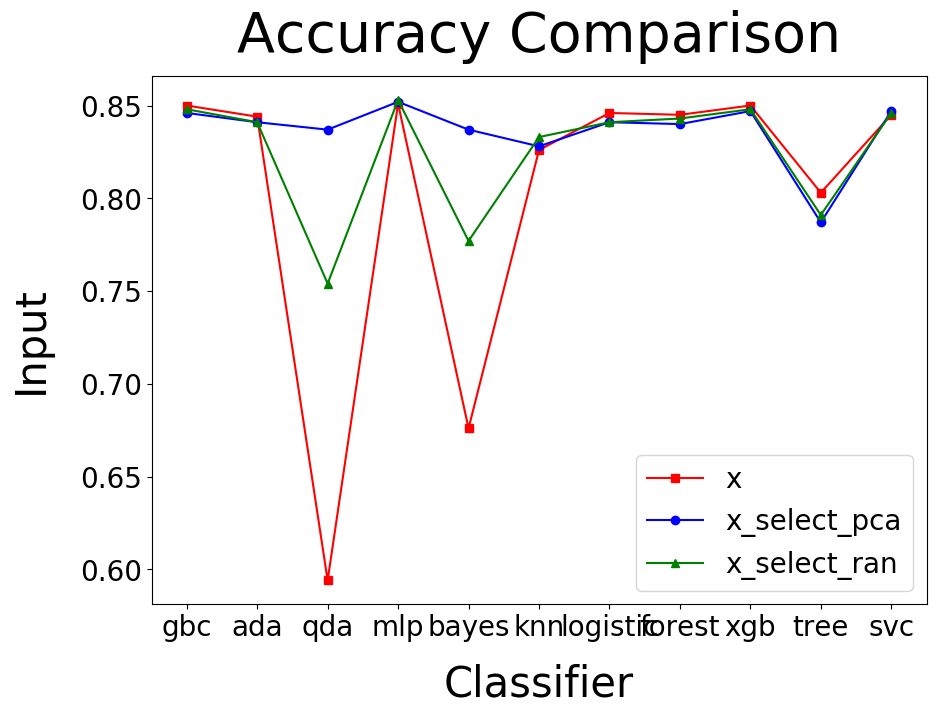

In [24]:
# Plot the accuracy comparison

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

xticks=["gbc","ada","qda","mlp","bayes","knn","logistic","forest","xgb","tree","svc"]
x_acc=out[:11]
x_select1_acc=out[11:22]
x_select2_acc=out[22:]
plt.figure(figsize=(10,7),dpi=100,linewidth = 2)
plt.plot(xticks,x_acc,'s-',color = 'r', label="x")
plt.plot(xticks,x_select1_acc,'o-',color = 'b', label="x_select_pca")
plt.plot(xticks,x_select2_acc,'^-',color = 'g', label="x_select_ran")
plt.title("Accuracy Comparison", x=0.5, y=1.03,fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Classifier", fontsize=30, labelpad = 15)
plt.ylabel("Input", fontsize=30, labelpad = 20)
plt.legend(loc = "best", fontsize=20)
plt.show()

### 2.5 Grid search for GradientBoosting, MLP, Xgboost (We chose due to the plot )

In [25]:
#1. Grid search for GradientBoosting (We found the important hyperparameters based on the API documents and we start from default setting then try higher or lower number.)

model=GradientBoostingClassifier()
param_grid = {'learning_rate':[0.1,0.05,0.2], 'n_estimators':[50,100,200],"max_depth":[2,3,4]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
0.8539418410212488


In [26]:
#2. Grid search for GradientBoosting (We found 0.2 for learning rate is the best so we tried bigger number, so does n_estimators.)

model=GradientBoostingClassifier()
param_grid = {'learning_rate':[0.3,0.2], 'n_estimators':[300,200],"max_depth":[2,3,4]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
0.8552469513438558


In [27]:
#3. Grid search for GradientBoostingClassifier (We searched the learning rate around 0.2 and n_estimators around 200. Futhermore, we tried higher max_depth.)

model=GradientBoostingClassifier()
param_grid = {'learning_rate':[0.2,0.25,0.15], 'n_estimators':[200,250,150],"max_depth":[4,5,6]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 150}
0.8562013132672621


In [28]:
#1. Grid search for MLPClassifier (We found the important hyperparameters based on the API documents and we start from default setting then try higher or lower number.)

model=MLPClassifier()
param_grid = {"hidden_layer_sizes":((200,),(100,),(50,))}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'hidden_layer_sizes': (100,)}
0.8524980627268649


In [29]:
#2. Grid search for MLPClassifier (We searched layer_sizes around 100.)

model=MLPClassifier()
param_grid = {"hidden_layer_sizes":((75,),(100,),(150,))}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'hidden_layer_sizes': (75,)}
0.852669358456707


In [30]:
#1. Grid search for XGBClassifier (We found the important hyperparameters based on the API documents and we start from default setting then try higher or lower number.)

model=xgb.XGBClassifier()
param_grid = {'eta':[0.2,0.3,0.4], 'max_depth':[6,7,5],"gamma":[0,10,100]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'eta': 0.2, 'gamma': 0, 'max_depth': 7}
0.855752681593866


In [31]:
#2. Grid search for XGBClassifier (We tried lower eta and higher max_depth.)

model=xgb.XGBClassifier()
param_grid = {'eta':[0.2,0.1], 'max_depth':[7,8,9]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'eta': 0.2, 'max_depth': 9}
0.8577103470777764


In [32]:
#3. Grid search for XGBClassifier (We tried higher max_depth.)

model=xgb.XGBClassifier()
param_grid = {'max_depth':[9,10,11]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_depth': 9}
0.8574901097108365


### 2.6 Voting ensemble


In [33]:
# I personally like to choose the best 3 classifier into vote from try and error.
# We used hyper parameter we found in grid search for the 3 classifier.

def vote(x,y):
    clf1 = xgb.XGBClassifier(max_depth=9)
    clf2 = GradientBoostingClassifier(learning_rate=0.15,max_depth=5,n_estimators=200)
    clf3 = MLPClassifier(hidden_layer_sizes = (75,))
    eclf = VotingClassifier(estimators=[('1', clf1), ('2', clf2), ('3', clf3)])
    scores = cross_val_score(eclf,x,y,cv=kf)
    print(round(scores.mean(),3))

vote(X,Y)
vote(x_select_pca,Y)
vote(x_select_ran,Y)

0.862
0.855
0.856


The f1 score is: 0.9098630701122208
The recall score is: 0.9529843101310185
The precision score is: 0.8704752524008865


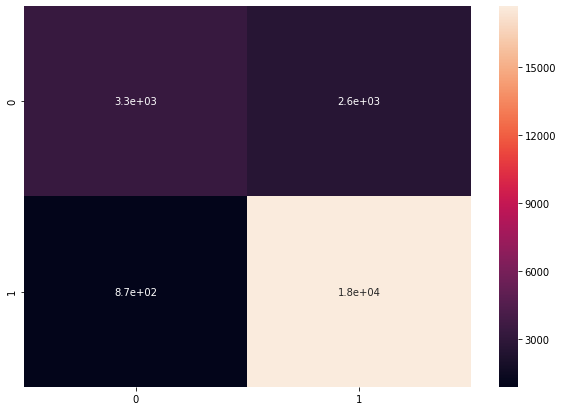

In [34]:
#Plot the confusion matrix and print the other scores.
#We used x_select_ran rather than X because it is much faster without losing a lot accuracy.

from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,average_precision_score
import seaborn as sn

xtrain,xtest,ytrain,ytest = train_test_split(x_select_ran,Y,test_size=0.2)
clf1 = xgb.XGBClassifier(max_depth=9)
clf2 = GradientBoostingClassifier(learning_rate=0.15,max_depth=5,n_estimators=200)
clf3 = MLPClassifier(hidden_layer_sizes = (75,))
classifier = VotingClassifier(estimators=[('1', clf1), ('2', clf2), ('3', clf3)]).fit(xtrain, ytrain)
ypred=classifier.predict(xtest)
matrix=confusion_matrix(ytest, ypred)
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True)

print("The f1 score is: "+str(f1_score(ytest, ypred)))
print("The recall score is: "+str(recall_score(ytest, ypred)))
print("The precision score is: "+str(precision_score(ytest, ypred)))

### 2.7 Neural network






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 98076 samples, validate on 24519 samples
Epoch 1/10





98076/98076 [==============================] - 33s 335us/step - loss: 0.4050 - acc: 0.8296 - val_loss: 0.3854 - val_acc: 0.8392
Epoch 2/10
98076/98076 [==============================] - 28s 286us/step - loss: 0.3725 - acc: 0.8467 - val_loss: 0.3707 - val_acc: 0.8440
Epoch 3/10
98076/98076 [==============================] - 28s 286us/step - loss: 0.3643 - acc: 0.8495 - val_loss: 0.3670 - val_acc: 0.8454
Epoch 4/10
98076/98076 [==============================] - 28s 284us/step - loss: 0.3608 - acc: 0.8504 - val_loss: 0.3633 - val_acc: 0.8453
Epoch 5/10
98076/98076 [==============================] - 28s 287us/step - loss: 0.3587 - acc: 0.8506 - val_loss: 0.3618 - val_acc: 0.8466
Epoch 6/10
98076/98076 [==============================] - 28s 284us/step - loss: 0.3574 - acc: 0.8508 - val_loss: 0.3601 - val_acc: 0.8468
Epoch 7/1

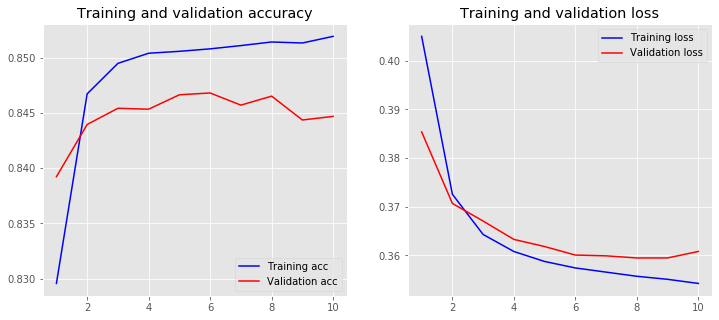

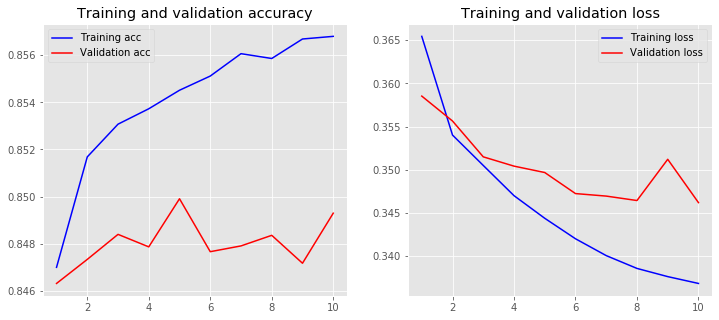

In [35]:
#To plot the results of Neural network

def plot(history):
    plt.style.use('ggplot')
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()  
    
#1. Neural network using Keras

xtrain,xtest,ytrain,ytest = train_test_split(np.array(x_select_ran),np.array(Y),test_size=0.2)
model = Sequential()
a=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,amsgrad=False)
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=a, metrics=['accuracy'])
com = model.fit(xtrain,ytrain,epochs=10,verbose=True,validation_data=(xtest, ytest),batch_size=20)
print(model.summary())
loss, accuracy = model.evaluate(xtrain, ytrain, verbose=False)
print("Training Accuracy:  {:.3f}".format(round(accuracy,2)))
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.3f}".format(round(accuracy,2)))
plot(com)

#2. Try different layers 
model = Sequential()
a=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,amsgrad=False)
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=a, metrics=['accuracy'])
com = model.fit(xtrain,ytrain,epochs=10,verbose=True,validation_data=(xtest, ytest),batch_size=20)
print(model.summary())
loss, accuracy = model.evaluate(xtrain, ytrain, verbose=False)
print("Training Accuracy:  {:.3f}".format(round(accuracy,2)))
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.3f}".format(round(accuracy,2)))
plot(com)